fps=19.9
a=0.011896591037904301
Computation took 0.004986286163330078s


<IPython.core.display.Javascript object>


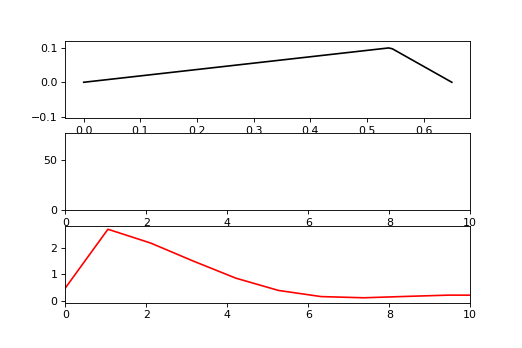

Animation took 6.510000467300415s


In [14]:
#1D non-uniform wave equation using explicit method

%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.animation as animation
from matplotlib import colors
import time

v=1            #propagation speed (m/s)
r=-0.01       #damping
n=100           #spatial points
l=200          #temporal points
E=20000            #Young's modulus
T0=10          #Unloaded tension (N)
[x1,x2]=[0,0.65]    #spatial boundaries (m)
[t1,t2]=[0,10]       #temporal boundaries (s)
dx=(x2-x1)/(n-1)     #spatial step size (m)
dt=(t2-t1)/(l-1)     #temporal step size (s)
x=np.linspace(x1,x2,n)
t=np.linspace(t1,t2,l)
L=x2-x1
fps=1/dt
print("fps="+str(fps))

gauss=np.exp(-1/4*(np.arange(-3,3))**2)

time0=time.time()

mu=578*np.ones(n-2)      #local linear mass density of low E = 82.41 Hz, 650 mm 0.00578 (10'000x slower)
T0=69
T=T0*np.ones(n-2)         #global tension based on length 69 N
tension=np.zeros(l-1)
V=(T/mu)**2            #squared unloaded local propagation speed m^2/s^2
#print(V)
a=(np.max(V)*dt/dx)**2         #<1 for stability
print("a="+str(a))
alpha=1/(1-r/(2*dt)*V) #1/alpha
beta=(1+r/(2*dt)*V)*alpha #helper term
if a>1:
    print(a)
    raise Exception("a>1, might encounter numerical instability")

u=np.zeros((l,n))  #the grid (time, space)
initial=np.ones(n)
initial[int(5/6*n):]=0
f=(x-x1)*0.1/(5/6*L)*initial + (x2-x)*0.1/(1/6*L)*(1-initial)            #np.sin(x*np.pi/L)+np.sin(2*x*np.pi/L)  #initial u(t=0)
g=np.zeros(n)    #initial u'(t=0)
#g[45:53]=4*np.exp(-1/2*(np.arange(-4,4)**2))
#plt.plot(x,f)
#plt.show()

u[0,:]=f
Lap0=(u[0,2:n]-2*u[0,1:n-1]+u[0,0:n-2])/(dx**2)
u[1,1:n-1]=(V/2*(dt**2)*alpha*Lap0 + 2*alpha*u[0,1:n-1] + 2*beta*dt*g[1:n-1])/(1+beta)
tension[0]=T0+E/2*np.sum((u[0,1:n]-u[0,0:n-1])**2)

for i in range(1,l-1):
    eps=1/2*np.sum((u[i,1:n]-u[i,0:n-1])**2)  #extra length under load
    T=T0+E*eps                                #tension
    V=V=(T/mu)**2                             #local propagation speed
    Lap=(u[i,2:n]-2*u[i,1:n-1]+u[i,0:n-2])/(dx**2)
    u[i+1,1:n-1]=V*(dt**2)*alpha*Lap + 2*alpha*u[i,1:n-1] - beta*u[i-1,1:n-1]
    #u[i+1,1:n-1]=-u[i-1,1:n-1]+a*(u[i,0:n-2]+u[i,2:n])+2*(1-a)*u[i,1:n-1]
    tension[i]=T

print("Computation took "+str(time.time()-time0)+"s")

fig=plt.figure()
ax=fig.add_subplot(311)
ax.set_ylim(1.2*np.min(u),1.2*np.max(u))
ax2=fig.add_subplot(312)
ax2.set_ylim(0,np.max(tension))
ax2.set_xlim(t1,t2)
ax3=fig.add_subplot(313)
ax3.set_xlim(0,10)
#fig2,ax2=plt.subplots()
#ylim((-2,2))   # set the ylim to bottom, top
#ylim(-2,1)

#kl=4
#uo=np.linspace(0,1,kl)
#print(uo)
#print(uo[0:4])
#print(uo[4])

#X,T=np.meshgrid(x,t)
#ax.plot_wireframe(X,T,u,color='blue')
#l,=ax2.plot(x,f)

#animate = lambda i: l.set_data(x,u[i,:])

#ani = animation.FuncAnimation(fig, animate, interval=30,frames=len(t))

#plt.show()

time1=time.time()
graph=None
tens=None
four=None
def animate(i):
    global graph,tens,four
    if graph:
        del ax.lines[0]
    if tens:
        del ax2.lines[0]
    if four:
        del ax3.lines[0]
    graph=ax.plot(x,u[i,:],color='black')#,cmap='magma',norm=colors.Normalize(vmin=np.min(u),vmax=np.max(u)),antialiased=False,shade=True)
    tens=ax2.plot(t[0:i],tension[0:i],color="blue")
    #print((u[:,int(5/6*L)]))
    four=ax3.plot(np.linspace(0,20,20),np.abs(np.fft.fft(u[:,int(5/6*n)]))[0:20],color="red")

ani = animation.FuncAnimation(fig, animate, interval=1000/fps,frames=l)

fn = 'wave_equation_plot_1D'
ani.save(fn+'.mp4',writer='ffmpeg',fps=int(fps),dpi=250)
ani

print("Animation took "+str(time.time()-time1)+"s")